In [64]:
#trial configuration

#Reward Zone
RZceil = 170 
RZfloor = 150

# 設定 binning window(min or trials)
binning_type = 'mins' # 'mins' or 'trials'
binning = 1

drop_start_licks_before = 30 #before position(cm)

In [3]:
#load data file
import os
import pandas as pd
from tkinter import Tk, filedialog
import matplotlib.pyplot as plt
import numpy as np

# 選取多個資料檔案

def get_file_paths():
    root = Tk()
    root.attributes('-topmost', True)  # 將主視窗設置為最上層
    root.withdraw()

    file_paths = []

    while True:
        files = filedialog.askopenfilenames(parent=root, title='選擇資料檔案', filetypes=[('CSV files', '*.csv')])
        if not files:
            break
        file_paths.extend(files)

    return file_paths

data_file_paths = get_file_paths()

all_raw_df = {}


# 循環處理每個選取的檔案
for index, data_file_dir in enumerate(data_file_paths):
    data_file_name = os.path.basename(data_file_dir)
    file_name_parts = data_file_name.split('_')
    mouseID = file_name_parts[0]
    Date = file_name_parts[1]
    schedule = file_name_parts[2]
    
    print("當前處理檔案:" + data_file_name)
    df = pd.read_csv(data_file_dir)
    
    if df.columns[0] != "Trial_number" or df.shape[1] != 8 :
        print("檔案格式錯誤")

    all_raw_df[index] = df


當前處理檔案:1PL001F_0307_30CTZ_150-170cm_12ul.csv
當前處理檔案:2PL002C_0307_30CTZ_150-170cm_12ul.csv
當前處理檔案:2PL002D_0307_30CTZ_150-170cm_12ul.csv


In [58]:
#各種函數

#(函數)提取某些資訊


#(函數)區分Trial成功失敗
def Trial_success_and_fail(all_raw_df, index):
    raw_df = all_raw_df[index]
    raw_df = raw_df.dropna()
    trial_df = raw_df.groupby("Trial_number")
    success_trial = pd.DataFrame([])
    fail_trial = pd.DataFrame([])

    for trial_number, group_data in trial_df:

        #找RZ裡的licking
        data_with_licking = group_data[group_data["Licking_count"].diff() != 0] 
        data_with_licking_RZfloor = data_with_licking[data_with_licking["Distance"] >= RZfloor]
        data_with_licking_RZfloor_RZceil = data_with_licking_RZfloor[data_with_licking_RZfloor["Distance"] <= RZceil]

        #如果RZ裡有licking
        if (len(data_with_licking_RZfloor_RZceil) > 0):
            success_trial = pd.concat([success_trial, group_data], axis=0, ignore_index=True)
        else:
            fail_trial = pd.concat([fail_trial, group_data], axis=0, ignore_index=True)

    return success_trial, fail_trial



#(函數)Trial_number的起始時間

def get_start_time_of_trial(index, trial_number):

    raw_df = all_raw_df[index]
    raw_df = raw_df.dropna()
    trial_start_time = raw_df[raw_df["Trial_number"] == trial_number]["Time"].iloc[0]

    return trial_start_time



#(函數)找到是否注射及其位置
def injection_trial(data_file_dir):
    data_file_name = os.path.basename(data_file_dir)
    file_name_parts = data_file_name.split('_')
    mouseID = file_name_parts[0]
    Date = file_name_parts[1]
    schedule = file_name_parts[2]
    if "CTZ" in schedule or "saline" in schedule or "baseline" in schedule:
        injection = True
        injection_trial = schedule[:2]
        
    else:
        injection = False
        injection_trial = np.nan
        
    return injection, injection_trial


#(函數)計算每個Trial中licking event發生位置的mean, var, std
def licking_statistic(all_raw_df, index):
    raw_df = all_raw_df[index]
    raw_df = raw_df.dropna()
    trial_df = raw_df.groupby("Trial_number")
    All_trial_licks = {}

    for trial_number, group_data in trial_df:

        # 找出 Licking_count 出現變化的行
        Licking_rows = group_data[group_data["Licking_count"].diff() != 0]
        Licking_rows = Licking_rows.drop(Licking_rows.index[0])
        if (len(Licking_rows.loc[Licking_rows['Distance'] >= 150])-len(Licking_rows.loc[Licking_rows['Distance'] >= 170])) > 0:
            first_lick_in_RZ = Licking_rows.loc[Licking_rows['Distance'] >= 150].iloc[0]
            first_lick_in_RZ = pd.DataFrame(first_lick_in_RZ)
            first_lick_in_RZ = first_lick_in_RZ.T
            Licking_rows = Licking_rows.loc[group_data["Distance"] < RZfloor]
            Licking_rows = Licking_rows.loc[group_data["Distance"] > drop_start_licks_before]
            Licking_rows = pd.concat([Licking_rows, first_lick_in_RZ], axis=0, ignore_index=True)
            trial_success = True

        else :
            Licking_rows = Licking_rows.loc[group_data["Distance"] < RZfloor]
            Licking_rows = Licking_rows.loc[group_data["Distance"] > drop_start_licks_before]
            trial_success = False
        
        if len(Licking_rows) == 0:
            lick_mean = pd.NA
            lick_var = pd.NA
            lick_std = pd.NA

        elif len(Licking_rows) == 1:
            lick_mean = RZfloor
            lick_var = 0
            lick_std = 0
            
        else:
            lick_mean = round(Licking_rows["Distance"].mean(), 2)
            lick_var = round(Licking_rows["Distance"].var(), 2)
            lick_std = round(Licking_rows["Distance"].std(), 2)
        
        trial_start_time = get_start_time_of_trial(index, trial_number)

        All_trial_licks[int(trial_number)] = {"success":trial_success,"trial_start_time": trial_start_time,
                                               "mean": lick_mean,"var": lick_var,"std": lick_std}

    All_trial_licks = pd.DataFrame(All_trial_licks)
    All_trial_licks = All_trial_licks.T
    All_trial_licks = All_trial_licks.sort_index()

    return All_trial_licks

def binning_statistic_within_session(all_raw_df, index,binning_type, binning):
    origin_statistic = licking_statistic(all_raw_df, index)
    binning_statistic = {}

    if binning_type == 'trials':   
        for i in range(0, len(origin_statistic), binning):
            trial_number = origin_statistic.index[i]
            binning_mean = origin_statistic["mean"].iloc[i:i+binning].mean()
            binning_std = origin_statistic["std"].iloc[i:i+binning].mean()
            std_of_mean_in_bin = origin_statistic["mean"].iloc[i:i+binning].std()
            binning_statistic[i] = {"X_axis": i+(binning/2), "trial_number": trial_number, 
                                    "binning_mean": binning_mean, "binning_std": binning_std, "std_of_mean_in_bin":std_of_mean_in_bin}
            binning_statistic = pd.DataFrame(binning_statistic)
        binning_statistic = binning_statistic.T
        binning_statistic.set_index('X_axis', inplace=True)
        binning_statistic = binning_statistic.sort_index()


    elif binning_type == 'mins':
        binning = int(binning * 60 * 1000) #轉換成ms
        binning_statistic = {}
        for index, i in enumerate(range(binning, int(origin_statistic["trial_start_time"].iloc[-1]), binning),start=1):
            selected_rows = origin_statistic[(origin_statistic['trial_start_time'] > i - binning) 
                                            & (origin_statistic['trial_start_time'] <= i)]
            if selected_rows.empty:
                trial_number = np.nan
                binning_mean = np.nan
                binning_std = np.nan
                std_of_mean_in_bin = np.nan
            else:
                trial_number = selected_rows.index[0]
                binning_mean = selected_rows["mean"].mean()
                binning_std = selected_rows["std"].mean()
                std_of_mean_in_bin = selected_rows["mean"].std()

            binning_statistic[index] = {"X_axis": int(i / 60000), "trial_number": trial_number, 
                                        "binning_mean": binning_mean,"binning_std": binning_std, "std_of_mean_in_bin":std_of_mean_in_bin}
            
        binning_statistic = pd.DataFrame(binning_statistic)
        binning_statistic = binning_statistic.T
        binning_statistic.set_index('X_axis', inplace=True)
        binning_statistic = binning_statistic.sort_index()
        
    return binning_statistic

def plot_statistic(grouped_binning_statistic, binning_type, binning, y_label, title):
    plt.figure(figsize=(10, 6))

    # 將NaN值替換為零
    grouped_binning_statistic.loc[:, (y_label, 'std')] = grouped_binning_statistic[y_label]['std'].fillna(0)

    if binning_type == 'trials':
        # 將資料分為兩部分
        before_trial30 = grouped_binning_statistic[grouped_binning_statistic.index < 30]
        after_trial30 = grouped_binning_statistic[grouped_binning_statistic.index > 30]

        #計算距離RZ的差距
        if y_label == 'binning_mean':
            before_trial30.loc[:, (y_label, 'mean')] = 150 - before_trial30[y_label]['mean']
            after_trial30.loc[:, (y_label, 'mean')] = 150 - after_trial30[y_label]['mean']

        # 繪製折線圖
        plt.plot(before_trial30.index, before_trial30[y_label]['mean'], '-o', color='blue')
        plt.plot(after_trial30.index, after_trial30[y_label]['mean'], '-o', color='red')

        # 添加半透明的錯誤範圍
        plt.fill_between(before_trial30.index, 
                        before_trial30[y_label]['mean'] - before_trial30[y_label]['std'], 
                        before_trial30[y_label]['mean'] + before_trial30[y_label]['std'], 
                        color='blue', alpha=0.2)

        plt.fill_between(after_trial30.index, 
                        after_trial30[y_label]['mean'] - after_trial30[y_label]['std'], 
                        after_trial30[y_label]['mean'] + after_trial30[y_label]['std'], 
                        color='red', alpha=0.2)

        plt.xlabel(binning_type)
        plt.ylabel(y_label)
        plt.title(title)
        plt.legend(['Before trial30', 'After trial30'])
        plt.xlim(left = 0)
        plt.ylim(bottom = 0)
        plt.show()
    
    elif binning_type == 'mins':
        # 計算距離RZ的差距
        if y_label == 'binning_mean':
            grouped_binning_statistic.loc[:, (y_label, 'mean')] = 150 - grouped_binning_statistic[y_label]['mean']

        # 繪製折線圖
        plt.plot(grouped_binning_statistic.index, grouped_binning_statistic[y_label]['mean'], '-o', color='blue')

        # 添加半透明的錯誤範圍
        plt.fill_between(grouped_binning_statistic.index, 
                        grouped_binning_statistic[y_label]['mean'] - grouped_binning_statistic[y_label]['std'], 
                        grouped_binning_statistic[y_label]['mean'] + grouped_binning_statistic[y_label]['std'], 
                        color='blue', alpha=0.2)

        plt.xlabel(binning_type)
        plt.ylabel(y_label)
        plt.title(title)
        plt.xlim(left = 0)
        plt.ylim(bottom = 0)
        plt.show()

def plot_binning_statistic(datasets_of_binning_statistic, binning_type, binning):
    # 合併所有的binning_statistic_within_session()輸出結果
    all_binning_statistic = pd.concat(datasets_of_binning_statistic.values())

    # 按照索引分組，並計算每組的平均值和標準差
    grouped_binning_statistic = all_binning_statistic.groupby(all_binning_statistic.index).agg(['mean', 'std'])

    # 繪製binning_mean折線圖
    plot_statistic(grouped_binning_statistic, binning_type, binning, 'binning_mean', 'Mean of Licking Distance in ' + str(binning) + ' ' + binning_type)

    # 繪製binning_std折線圖
    plot_statistic(grouped_binning_statistic, binning_type, binning, 'binning_std', 'Std of Licking Distance in ' + str(binning) + ' ' + binning_type)

    # 繪製std_of_mean_in_bin折線圖
    plot_statistic(grouped_binning_statistic, binning_type, binning, 'std_of_mean_in_bin', 'Std of Mean of Licking Distance in ' + str(binning) + ' ' + binning_type)

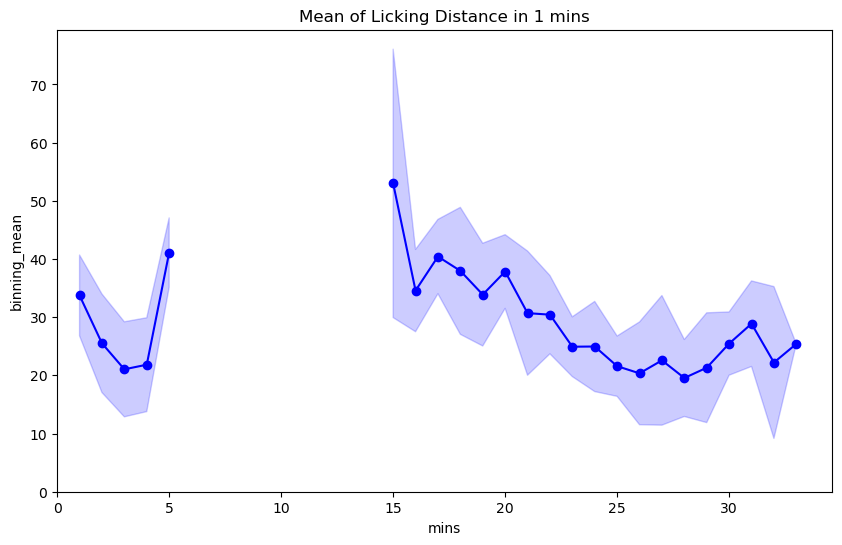

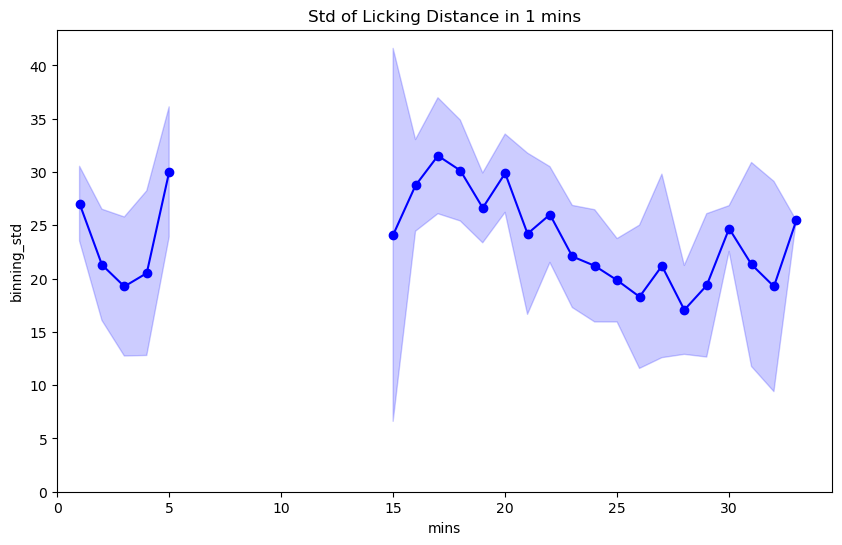

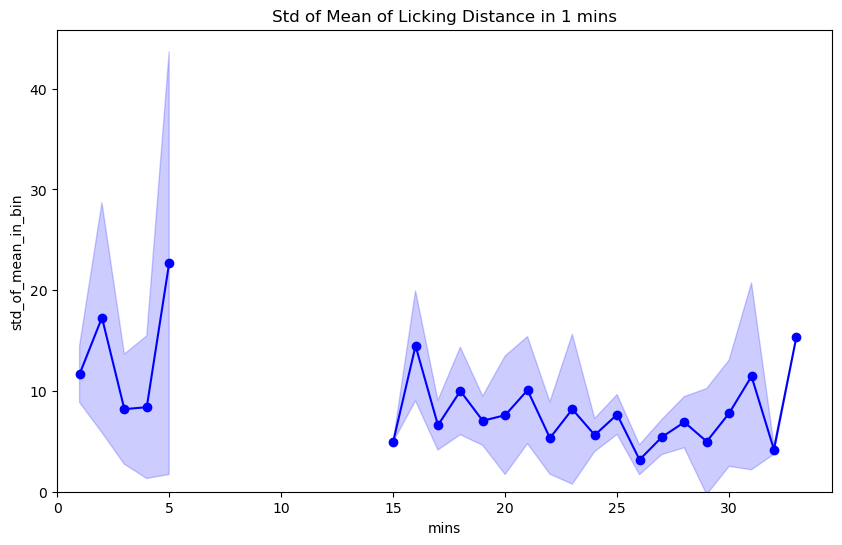

In [65]:
#plot the binning statistic
datasets_of_binning_statistic = {}
for index, raw_df in all_raw_df.items():
    datasets_of_binning_statistic[index] = binning_statistic_within_session(all_raw_df, index, binning_type, binning)

plot_binning_statistic(datasets_of_binning_statistic, binning_type, binning)